## Транспортные пробки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d

# make a directory for figures
!mkdir figures

from os.path import basename, exists
def download(url):
    fileName = basename(url)
    if not exists(fileName):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, fileName)
        print(f'Downloaded {local}')

download('https://github.com/wernadsky/test/raw/master/cell2d.py')
download('https://github.com/wernadsky/test/raw/master/utils.py')

from cell2d import Cell2D, draw_array, three_frame
from utils import decorate

A subdirectory or file figures already exists.


In [2]:
class Driver:
    def __init__(self, loc, speed=4):
        """
        loc: позиция на дороге автомобиля
        speed: скорость автомобиля
        """
        self.start = loc
        self.loc = loc
        self.speed = speed

    def chooseAcceleration(self, dist):
        return 1

    def setOdometer(self):
        self.start = self.loc

    def readOdometer(self):
        return self.loc - self.start

In [3]:
class Highway(Cell2D):

    maxAcc = 1
    minAcc = -10
    speedLimit = 40

    def __init__(self, n=10, length=1000, eps=0, consturctor=Driver):
        """Инициализация атрибутов.

        n: int - число машин (drivers)
        lenght: int - длина пути
        eps: int - изменчивость в значениях скоростей
        consturctor: функция для инициализации водитетей 
        """
        self.lenght = length
        self.eps = eps
        self.crashes = 0

        # создание участников движения
        # начальное расположение машин на дороге:
        locs = np.linspace(0, length, n, endpoint=False)
        self.drivers = [consturctor(loc) for loc in locs]

        # линкуем машины, расположенные друг за другом
        for i in range(n):  # j - индекс автомобиля, расположенного за i
            j = (i+1) % n   # дорога закользована
            self.drivers[i].next = self.drivers[j]

    def step(self):
        for driver in self.drivers:
            self.move(driver)

    def move(self, driver):
        # получим расстояние до следующей машины
        dist = self.distance(driver)
        # ускорение автомобиля
        acc = driver.chooseAcceleration(dist)
        acc = min(acc, self.maxAcc)     # ограничение ускорения
        acc = max(acc, self.minAcc)     # сверху и снизу
        speed = driver.speed + acc

        # добавим шум в скорость
        speed *= np.random.uniform(1-self.eps, 1+self.eps)

        speed = max(speed, 0)               # ограничение скорости
        speed = min(speed, self.speedLimit) # сверху и снизу

        # если текущая скорость автомобиля приводит к столкновению
        # со следующим авто, то автомобиль останавливается:
        if speed > dist:
            speed = 0
            self.crashes += 1

        driver.speed = speed    # обновляем данные скорости
        driver.loc += speed     # и координаты автомобилиста

    def distance(self, driver):
        """Расстояние от автомобиля до следующего авто.
        
        driver: Driver object
        """
        dist = driver.next.loc - driver.loc

        # исправляем случай, когда следующий автомобиль находися
        # за точкой замыкания дороги |--2--------1--| 
        if dist < 0:
            dist += self.lenght
        return dist
    
    def setOdometers(self):
        return [driver.setOdometer() for driver in self.drivers]

    def readOdometers(self):
        return np.mean([driver.readOdometer() for driver in self.drivers])

    def draw(self, size=None):
        # отрисовка машин:
        drivers = self.drivers
        xs, ys = self.getCoords(drivers)
        plt.plot(xs, ys, 'bs', markersize=10, alpha=0.7)

        # отрисовка столкновений:
        stopped = [driver for driver in self.drivers if driver.speed==0]
        xs, ys = self.getCoords(stopped, r=0.8)
        plt.plot(xs, ys, 'r^', markersize=10, alpha=0.7)

        plt.axis('off')
        plt.axis('equal')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

    def getCoords(self, drivers, r=1):
        """Получить координаты автомобилей
        
        drivers: последовательность объектов класса Driver
        r: радиус дороги
        returns: кортеж последовательностей (xs, ys)
        """
        locs = np.array([driver.loc for driver in drivers])
        locs *= 2 * np.pi / self.lenght
        xs = r * np.cos(locs)
        ys = r * np.sin(locs)
        return xs, ys

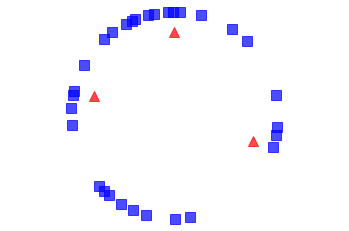

In [4]:
highway = Highway(30, eps=0.02)
fig = highway.animate(frames=50, interval=0.2)

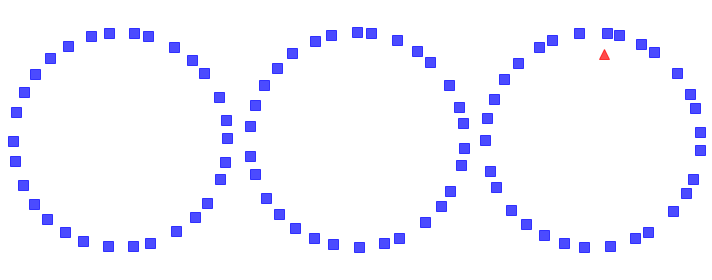

In [21]:
from cell2d import three_frame

highway = Highway(30, eps=0.02)
fig = three_frame(highway, [16, 1, 1])